In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # For date formatting on plots
import pickle
import datetime
from sklearn.model_selection import train_test_split


# --- Constants ---
TOTAL_UNITS_TO_SELL_PER_DAY = 100
# !!! SET THIS TO A VALID TRADING DAY FROM YOUR DATASET !!!
DETAILED_TEST_DAY_STR = '2025-04-17' # Example: Make sure this date exists in your dataset


from utils import (load_data,
                   plot_detailed_day_simulation)
from features import add_features

hsi_df, hsfi_df, hscat100_df = load_data()



In [2]:
def even_interval_one_unit_logic(tradeable_today_featured_data, units_left, steps_left,
                            in_trading_args, model,
                            initial_units_target_for_period: int = TOTAL_UNITS_TO_SELL_PER_DAY,):
    if steps_left == 0:
        return units_left
    if units_left <= 1e-9:
        return 0.0
    # Calculate the interval step based on the total timestamp and the initial units target
    interval_step = in_trading_args["steps_today_total"] / initial_units_target_for_period
    # Calculate the current position within the period
    current_position = in_trading_args["steps_today_total"] - steps_left
    # Check if current_position is at an interval step (considering floating point precision)
    if abs(current_position % interval_step) < 1e-9 or abs(interval_step - (current_position % interval_step)) < 1e-9:
        return 1.0
    else:
        return 0.0

def long_short_moving_average_logic(tradeable_today_featured_data, units_left, steps_left, 
                                    in_trading_args, model, initial_units_target_for_period: int = TOTAL_UNITS_TO_SELL_PER_DAY,):
    step_i = in_trading_args["steps_today_total"] - steps_left - 1
    in_trading_args["steps_since_last_sale"] += 1
    if steps_left == 0: return units_left
    if units_left <= 1e-9: return 0.0
    tradeable_today_step_featured_data = tradeable_today_featured_data.iloc[step_i]
    base_sell_amount = (units_left / (steps_left//initial_units_target_for_period + 1)) *\
        in_trading_args["steps_since_last_sale"] / initial_units_target_for_period
    sma_short, sma_long = tradeable_today_step_featured_data['ma_5'], tradeable_today_step_featured_data['ma_20']
    if pd.isna(sma_long) or sma_long == 0 or pd.isna(sma_short) or sma_short == 0: return 0 
    if sma_short > sma_long:
        in_trading_args["steps_since_last_cond_meet"] += 1
        if in_trading_args["steps_since_last_cond_meet"] > 3 and base_sell_amount>0.5:
            in_trading_args["steps_since_last_cond_meet"] = 0
            in_trading_args["steps_since_last_sale"] = 0
            return 1.0
    return 0.0

def moving_average_logic(tradeable_today_featured_data, units_left, steps_left,
                         in_trading_args, model, 
                         initial_units_target_for_period: int = TOTAL_UNITS_TO_SELL_PER_DAY,):
    step_i = in_trading_args["steps_today_total"] - steps_left - 1
    in_trading_args["steps_since_last_sale"] += 1
    if steps_left == 0: return units_left
    if units_left <= 1e-9: return 0.0
    tradeable_today_step_featured_data = tradeable_today_featured_data.iloc[step_i]
    base_sell_amount = (units_left / (steps_left//initial_units_target_for_period + 1)) *\
        in_trading_args["steps_since_last_sale"] / initial_units_target_for_period
    price, sma_long = tradeable_today_step_featured_data['close'], tradeable_today_step_featured_data['ma_20']
    if pd.isna(sma_long) or sma_long == 0: return base_sell_amount 
    if price > sma_long:
        in_trading_args["steps_since_last_cond_meet"] += 1
        if in_trading_args["steps_since_last_cond_meet"] > 5 and base_sell_amount>0.5:
            in_trading_args["steps_since_last_cond_meet"] = 0
            in_trading_args["steps_since_last_sale"] = 0
            return 1.0
    elif price <= sma_long: return 0.0
    return 0.0

def momentum_logic(
    tradeable_today_featured_data: pd.DataFrame,
    units_left: float,
    steps_left: int,
    in_trading_args: dict,
    model,  # Unused
    # --- Parameters for the BASE peak significance (dynamic threshold) ---
    # This is the minimum ROC peak value to even *consider* selling,
    # before checking rarity tiers. Adjusted for assumed ROC scaling (0.05% = 0.0005).
    base_roc_min_peak_value: float = 0.0005, # e.g., 0.05%
    initial_units_target_for_period: int = TOTAL_UNITS_TO_SELL_PER_DAY,
    # Sensitivity: How much the base_roc_min_peak_value is lowered per unit of shortfall.
    # e.g., 0.00001 means 0.001% ROC reduction per unit of shortfall.
    roc_threshold_shortfall_sensitivity: float = 0.00001,
    # Min base threshold: Ensure dynamic_roc_threshold doesn't go below this.
    # e.g., 0.00005 means 0.005%
    min_roc_threshold_after_adjustment: float = 0.00005,
    rarity_config: dict = {
            "roc_15min": [[ 0.00539, 4 ], [0.00286, 2], [0.00178, 1]],
            "roc_20min": [[ 0.00905, 4 ], [0.00579, 2], [0.00402, 1]],
        }
):
    """
    Momentum logic that sells units proportional to ROC ascend rarity.
    1. Detects a peak in ROC (increasing then decreasing).
    2. Checks if the peak's ROC value meets a dynamically adjusted base significance threshold.
    3. If significant, compares the peak's ROC value against configured rarity thresholds.
    4. Sells a number of integer units corresponding to the highest rarity level achieved.
    5. Adjusts the base significance threshold based on selling progress (time/inventory pressure).
    """

    current_total_steps = in_trading_args["steps_today_total"]
    # Calculate current step index (0-based)
    step_i = current_total_steps - steps_left - 1

    if steps_left == 0: # No units left to sell
        return 0.0
    if units_left <= 1e-9: # Effectively zero units left (handle float precision)
        return 0.0
    if steps_left == 0 and units_left > 0: # Last step, try to sell remaining
        return float(int(units_left)) # Ensure int units

    # --- Dynamic Base ROC Threshold Calculation ---
    dynamic_roc_threshold = base_roc_min_peak_value
    if current_total_steps > 0 and steps_left > 0: # Avoid division by zero if steps_today_total is 0
        ideal_units_sold_by_now = initial_units_target_for_period * (step_i + 1) / current_total_steps
        units_actually_sold_so_far = initial_units_target_for_period - units_left
        selling_shortfall = ideal_units_sold_by_now - units_actually_sold_so_far

        # If we are ahead or on track (shortfall <= 0), we can be more conservative
        # If we are behind (shortfall > 0), we lower the threshold to be more aggressive
        threshold_adjustment = selling_shortfall * roc_threshold_shortfall_sensitivity
        dynamic_roc_threshold = base_roc_min_peak_value - threshold_adjustment
        dynamic_roc_threshold = max(min_roc_threshold_after_adjustment, dynamic_roc_threshold)

    # Need at least 3 data points to detect a peak (prev-prev, prev, current)
    if step_i >= 2:
        for roc_col_name in rarity_config:
            roc_series = tradeable_today_featured_data[roc_col_name]
            roc_at_current_step = roc_series.iloc[step_i]
            roc_at_prev_step = roc_series.iloc[step_i-1]
            roc_at_prev_prev_step = roc_series.iloc[step_i-2]

            if pd.notna(roc_at_prev_prev_step) and \
            pd.notna(roc_at_prev_step) and \
            pd.notna(roc_at_current_step):
                condition_roc_was_increasing = (roc_at_prev_step > roc_at_prev_prev_step)
                condition_roc_is_decreasing = (roc_at_prev_step > roc_at_current_step)
                condition_peak_meets_base_threshold = (roc_at_prev_step > dynamic_roc_threshold)

                if condition_roc_was_increasing and \
                condition_roc_is_decreasing and \
                condition_peak_meets_base_threshold:
                    units_to_sell_candidate = 0
                    roc_peak_value = roc_at_prev_step

                    if roc_peak_value > rarity_config[roc_col_name][0][0]:
                        units_to_sell_candidate = rarity_config[roc_col_name][0][1]
                    elif roc_peak_value > rarity_config[roc_col_name][1][0]:
                        units_to_sell_candidate = rarity_config[roc_col_name][1][1]
                    elif roc_peak_value > rarity_config[roc_col_name][2][0]:
                        units_to_sell_candidate = rarity_config[roc_col_name][2][1]

                    if units_to_sell_candidate > 0:
                        # Ensure units are integer and do not exceed units_left
                        sell_amount = min(int(units_to_sell_candidate), int(units_left))
                        return float(sell_amount)
    return 0.0

def lstm_proxy_logic(tradeable_today_featured_data, units_left, steps_left, in_trading_args,
                    model, aggression=0.5, initial_units_target_for_period: int = TOTAL_UNITS_TO_SELL_PER_DAY,):
    if steps_left == 0: return units_left
    if units_left <= 1e-9: return 0.0
    step_i = in_trading_args["steps_today_total"] - steps_left - 1
    base_sell_amount = units_left / (steps_left + 1)
    current_price = tradeable_today_featured_data['close'].iloc[step_i]
    predicted_price = tradeable_today_featured_data['Price_Pred_Simple'].iloc[step_i]
    if pd.isna(predicted_price) or pd.isna(current_price): return base_sell_amount
    # If predicted price is lower than current, means price expected to drop, so sell more
    if predicted_price < current_price: return base_sell_amount * (1 + aggression)
    # If predicted price is higher, means price expected to rise, so sell less
    elif predicted_price > current_price: return base_sell_amount * (1 - aggression)
    return base_sell_amount

# --- GBDT Strategy Logic (Modified for new target interpretation) ---
def gbdt_strategy_logic(tradeable_today_featured_data: pd.DataFrame,
                        units_left, steps_left, in_trading_args, model, 
                        prediction_change_threshold=0.0005,
                        base_roc_min_peak_value: float = 0.0005, # e.g., 0.05%
                        initial_units_target_for_period: int = TOTAL_UNITS_TO_SELL_PER_DAY,): # Uses global GBDT_FEATURE_COLUMNS
    if steps_left == 0: return units_left
    if units_left <= 1e-9: return 0.0
    step_i = in_trading_args["steps_today_total"] - steps_left - 1
    predicted_sale_units = model.predict(
        pd.DataFrame([tradeable_today_featured_data.iloc[step_i]], columns=tradeable_today_featured_data.columns))[0]
    if predicted_sale_units < 2: return 0
    return predicted_sale_units
    
def get_tradeable_data(df_daily_features):
    """Filters the DataFrame to include only tradeable minutes for a single day."""
    morning_trade_start = datetime.time(9, 45)
    morning_trade_end = datetime.time(11, 44, 59) 
    afternoon_trade_start = datetime.time(13, 15)
    afternoon_trade_end = datetime.time(15, 44, 59)

    times = df_daily_features.index.time
    is_in_morning_tradeable = (times >= morning_trade_start) & (times <= morning_trade_end)
    is_in_afternoon_tradeable = (times >= afternoon_trade_start) & (times <= afternoon_trade_end)
    tradeable_mask = is_in_morning_tradeable | is_in_afternoon_tradeable
    return df_daily_features[tradeable_mask]


def execute_trades(tradeable_today_featured_data, total_units_to_sell, 
                   algo_logic_func, algo_name="Algo", trained_model=None):
    trades = []
    units_remaining = float(total_units_to_sell) # Ensure units_remaining is float
    cash_accumulated = 0.0
    
    if tradeable_today_featured_data.empty:
        # print(f"Warning: No tradeable data for {algo_name} on this day.")
        return pd.DataFrame(trades), cash_accumulated

    in_trading_args = {"steps_since_last_sale": 0,
                       "steps_since_last_cond_meet": 0,
                       "steps_today_total": len(tradeable_today_featured_data)}
    for i in range(len(tradeable_today_featured_data)):
        if units_remaining <= 1e-9: # Using a small epsilon for float comparison
            break
        
        current_time = tradeable_today_featured_data.index[i]
        current_price = tradeable_today_featured_data['close'].iloc[i]
        steps_left = len(tradeable_today_featured_data) - 1 - i

        nominal_units_to_sell_decision = 0.0
        if steps_left == 0:
            # Last trading opportunity in the defined tradeable period for the algo, sell all remaining.
            # This can be a fractional amount.
            raw_algo_decision = units_remaining
        else:
            if algo_name == "GBDTStrategy":
                raw_algo_decision = gbdt_strategy_logic(tradeable_today_featured_data, units_remaining, steps_left, 
                                                    in_trading_args, trained_model)
            elif algo_name == "LongShortMovingAverage":
                raw_algo_decision = long_short_moving_average_logic(tradeable_today_featured_data, units_remaining, steps_left, 
                                                    in_trading_args, trained_model)
            elif algo_name == "MovingAverage":
                raw_algo_decision = moving_average_logic(tradeable_today_featured_data, units_remaining, steps_left, 
                                                    in_trading_args, trained_model)
            elif algo_name == "Momentum":
                raw_algo_decision = momentum_logic(tradeable_today_featured_data, units_remaining, steps_left, 
                                                    in_trading_args, trained_model)
            elif algo_name == "LSTMProxy":
                raw_algo_decision = lstm_proxy_logic(tradeable_today_featured_data, units_remaining, steps_left, 
                                                    in_trading_args, trained_model)
            elif algo_name == "EvenIntervalSell":
                raw_algo_decision = even_interval_one_unit_logic(tradeable_today_featured_data, units_remaining, steps_left, 
                                                    in_trading_args, trained_model)
        
        if raw_algo_decision<=0.5:
            continue
        elif raw_algo_decision<=1:
            nominal_units_to_sell_decision = 1
        else:
            nominal_units_to_sell_decision = int(raw_algo_decision)

        # Cap the decision by available units and ensure it's not negative. This value is still float.
        capped_units_to_sell_float = max(0.0, min(nominal_units_to_sell_decision, units_remaining))

        # For algorithmic steps (not the final step in the loop), convert to integer.
        # The final step (steps_left == 0) sells the exact (potentially fractional) remaining amount.
        if steps_left == 0:
            units_to_sell_this_step = capped_units_to_sell_float 
        else:
            # Per requirement, units_to_sell_this_step must be an integer for algo-driven steps.
            units_to_sell_this_step = float(capped_units_to_sell_float) 
        
        if units_to_sell_this_step > 1e-9: # Sell if more than a tiny fraction (effectively > 0 for integers)
            trades.append({
                'timestamp': current_time, 
                'units_sold': int(units_to_sell_this_step), # Store as float in trades list
                'close': current_price, 
                'value': float(units_to_sell_this_step) * current_price
            })
            units_remaining -= float(units_to_sell_this_step)
            cash_accumulated += float(units_to_sell_this_step) * current_price
            units_remaining = max(0.0, units_remaining) # Ensure units_remaining doesn't go negative
    
    # If any units remain after the loop, force sell them at the last available price.
    # This handles fractions left over from int conversions or if algo didn't sell all.
    if units_remaining > 1e-9 and not tradeable_today_featured_data.empty:
        last_price = tradeable_today_featured_data['close'].iloc[-1]
        # print(f"INFO: {algo_name} force selling {units_remaining:.2f} units at EOD.")
        trades.append({
            'timestamp': tradeable_today_featured_data.index[-1], 
            'units_sold': units_remaining, # Sell the exact fractional amount remaining
            'close': last_price, 
            'value': units_remaining * last_price
        })
        cash_accumulated += units_remaining * last_price
        units_remaining = 0.0 
        
    return pd.DataFrame(trades), cash_accumulated

In [9]:
# --- 5. Main Simulation Orchestration ---
from gdbt_2nd import prepare_then_get_gbdt_model


def prepare_simulation(hsi_df, hsfi_df, hscat100_df):

    if hsi_df.empty or len(hsi_df) < 60: # Ensure some data
        print("Insufficient data loaded. Exiting simulation.")
        return
    
    plt.style.use('seaborn-v0_8-whitegrid')
    print(f"Loaded {len(hsi_df)} HSI data points from {hsi_df.index.min()} to {hsi_df.index.max()}")

    featured_data_full = add_features(hsi_df, hsfi_df, hscat100_df)
    featured_data_full.head()
    
    all_unique_dates_ts = sorted(list(featured_data_full.index.normalize().unique()))
    
    try:
        detailed_test_date_ts = pd.to_datetime(DETAILED_TEST_DAY_STR).normalize()
    except ValueError:
        print(f"Error: DETAILED_TEST_DAY_STR '{DETAILED_TEST_DAY_STR}' is not a valid date format.")
        if all_unique_dates_ts:
            detailed_test_date_ts = all_unique_dates_ts[-1]
            print(f"Using fallback test day: {detailed_test_date_ts.strftime('%Y-%m-%d')}")
        else: return 
            
    if detailed_test_date_ts not in all_unique_dates_ts:
        print(f"Warning: DETAILED_TEST_DAY_STR {DETAILED_TEST_DAY_STR} not found in dataset.")
        if all_unique_dates_ts:
            detailed_test_date_ts = all_unique_dates_ts[-1]
            print(f"Using fallback test day: {detailed_test_date_ts.strftime('%Y-%m-%d')}")
        else:
            print("No unique dates in dataset. Cannot proceed.")
            return
            
    other_dates_ts = [d for d in all_unique_dates_ts if d != detailed_test_date_ts]

    if len(other_dates_ts) < 2:
        gbdt_train_dates = other_dates_ts
        gbdt_validation_dates = []
    else:
        validation_split_size = min(0.25, (len(other_dates_ts) -1) / len(other_dates_ts) if len(other_dates_ts)>1 else 0.1)
        if validation_split_size <= 0 :
             gbdt_train_dates = other_dates_ts
             gbdt_validation_dates = []
        else:
             gbdt_train_dates, gbdt_validation_dates = train_test_split(other_dates_ts, test_size=validation_split_size, random_state=42, shuffle=True)

    trained_gbdt_model = prepare_then_get_gbdt_model(featured_data_full, gbdt_train_dates, gbdt_validation_dates)
    
    algorithms = {
        "GBDTStrategy": lambda cf, ul, sl, args, model: gbdt_strategy_logic(cf, ul, sl, args, model),
        "LongShortMovingAverage": lambda cf, ul, sl, args, model: long_short_moving_average_logic(cf, ul, sl, args, model),
        "MovingAverage": lambda cf, ul, sl, args, model: moving_average_logic(cf, ul, sl, args, model),
        # "Momentum": lambda cf, ul, sl, args, model: momentum_logic(cf, ul, sl, args, model),
        # "LSTMProxy": lambda cf, ul, sl, args, model: lstm_proxy_logic(cf, ul, sl, args, model),
        "EvenIntervalSell": lambda cf, ul, sl, args, model: even_interval_one_unit_logic(cf, ul, sl, args, model)
    }

    import pickle

    # Save
    with open('trained_gbdt_model.pkl', 'wb') as f:
        pickle.dump(trained_gbdt_model, f)
    
    return featured_data_full, all_unique_dates_ts, detailed_test_date_ts, algorithms

def run_simulation(featured_data_full, detailed_test_date_ts, all_unique_dates_ts, algorithms):

    all_daily_simulation_results = []
    # TOTAL_UNITS_TO_SELL_PER_DAY needs to be defined, e.g.,
    # TOTAL_UNITS_TO_SELL_PER_DAY = 100
    # DETAILED_TEST_DAY_STR should also be defined, e.g.,
    # DETAILED_TEST_DAY_STR = '2025-04-15'

        # Load
    with open('trained_gbdt_model.pkl', 'rb') as f:
        trained_gbdt_model = pickle.load(f)

    print(f"\n--- Running Daily Simulations (Target: Sell {TOTAL_UNITS_TO_SELL_PER_DAY} units/day) ---")
    for day_ts in all_unique_dates_ts:
        current_day_full_data = featured_data_full[featured_data_full.index.normalize() == day_ts]
        if current_day_full_data.empty:
            continue

        tradeable_today_featured_data = get_tradeable_data(current_day_full_data)
        
        # --- MODIFICATION FOR PLOTTING ---
        trades_for_detailed_plot_on_this_day = {} # Collect trades for each algo on this day if it's the detailed test day
        # --- END MODIFICATION ---

        if tradeable_today_featured_data.empty:
            # ... (your existing logic for no tradeable minutes) ...
            for algo_name_key in algorithms.keys():
                 all_daily_simulation_results.append({
                    "Date": day_ts.strftime('%Y-%m-%d'), "Algorithm": algo_name_key,
                    "Total Cash": 0, "Avg Sell Price": 0, "Units Sold": 0, 
                    "Return vs Arrival": 0, "StdDev Prices": 0, "Sharpe": 0, "Trades": 0
                })
            continue # Skip to next day if no tradeable data

        arrival_price_today = tradeable_today_featured_data['close'].iloc[0]

        for name, logic_func_lambda in algorithms.items():
            trades_df_today, total_cash_today = execute_trades(
                tradeable_today_featured_data, TOTAL_UNITS_TO_SELL_PER_DAY, 
                logic_func_lambda, name, 
                trained_model=trained_gbdt_model if name == "GBDTStrategy" else None
            )
            
            # --- MODIFICATION FOR PLOTTING ---
            if day_ts == detailed_test_date_ts:
                trades_for_detailed_plot_on_this_day[name] = trades_df_today
            # --- END MODIFICATION ---
            
            # ... (your existing result calculation logic) ...
            total_units_sold_today = trades_df_today['units_sold'].sum() if not trades_df_today.empty else 0
            avg_sell_price_today = 0; weighted_std_dev_sell_prices_today = 0
            
            if total_units_sold_today > 1e-6:
                avg_sell_price_today = total_cash_today / total_units_sold_today
                if len(trades_df_today) > 1:
                    weighted_std_dev_sell_prices_today = np.sqrt(np.average((trades_df_today['close'] - avg_sell_price_today)**2, weights=trades_df_today['units_sold']))
            
            effective_return_vs_arrival_today = avg_sell_price_today - arrival_price_today if avg_sell_price_today > 0 else 0.0
            sharpe_ratio_today = 0.0
            if weighted_std_dev_sell_prices_today > 1e-6 : sharpe_ratio_today = effective_return_vs_arrival_today / weighted_std_dev_sell_prices_today
            elif effective_return_vs_arrival_today > 1e-9 : sharpe_ratio_today = np.inf
            elif effective_return_vs_arrival_today < -1e-9 : sharpe_ratio_today = -np.inf
            
            all_daily_simulation_results.append({
                "Date": day_ts.strftime('%Y-%m-%d'), "Algorithm": name,
                "Total Cash": total_cash_today, "Avg Sell Price": avg_sell_price_today,
                "Units Sold": total_units_sold_today, "Return vs Arrival": effective_return_vs_arrival_today,
                "StdDev Prices": weighted_std_dev_sell_prices_today, "Sharpe": sharpe_ratio_today,
                "Trades": len(trades_df_today)
            })


        # After processing all algorithms for the day, check if it's the detailed test day to plot
        if day_ts == detailed_test_date_ts and trades_for_detailed_plot_on_this_day:
            print(f"\nPlotting detailed simulation for all strategies on {day_ts.strftime('%Y-%m-%d')}")
            plot_detailed_day_simulation(
                current_day_full_data,                      # Full HSI data for the day (1-min res)
                trades_for_detailed_plot_on_this_day,       # Dict of trades_df for each algo
                day_ts.date(),                              # The date object for titles
                TOTAL_UNITS_TO_SELL_PER_DAY                 # Target units for the day
            )

    if not all_daily_simulation_results:
        print("No simulation results to display.")
        return

    results_df = pd.DataFrame(all_daily_simulation_results)
    results_df['Sharpe'] = results_df['Sharpe'].replace([np.inf, -np.inf], np.nan) 

    print("\n--- Average Daily Performance Across All Simulated Days ---")
    summary_stats = []
    for algo in results_df['Algorithm'].unique():
        algo_df = results_df[results_df['Algorithm'] == algo]
        total_cash_algo = algo_df['Total Cash'].sum()
        total_units_algo = algo_df['Units Sold'].sum()
        
        overall_avg_sell_price = total_cash_algo / total_units_algo if total_units_algo > 0 else 0
        # Filter out days with zero units sold for calculating average return and sharpe if they are per-unit metrics
        valid_trade_days = algo_df[algo_df['Units Sold'] > 0]
        avg_daily_return_vs_arrival = valid_trade_days['Return vs Arrival'].mean() if not valid_trade_days.empty else 0
        avg_daily_sharpe = valid_trade_days['Sharpe'].mean() if not valid_trade_days.empty else 0
        avg_daily_trades = algo_df['Trades'].mean()

        summary_stats.append({
            "Algorithm": algo,
            "Overall Avg Sell Price": overall_avg_sell_price,
            "Avg Daily Cash": algo_df['Total Cash'].mean(),
            "Avg Daily Units Sold": algo_df['Units Sold'].mean(),
            "Avg Daily Return vs Arrival": avg_daily_return_vs_arrival,
            "Avg Daily Sharpe": avg_daily_sharpe, 
            "Avg Daily Trades": avg_daily_trades,
            "Total Days Simulated": algo_df['Date'].nunique()
        })
    
    summary_df = pd.DataFrame(summary_stats).set_index("Algorithm").sort_values(by="Overall Avg Sell Price", ascending=False)
    pd.set_option('display.float_format', '{:.2f}'.format) 
    print(summary_df)



In [10]:
featured_data_full, all_unique_dates_ts, detailed_test_date_ts, algorithms = prepare_simulation(hsi_df, hsfi_df, hscat100_df)


Loaded 19860 HSI data points from 2025-02-03 09:30:00 to 2025-04-30 16:00:00
Feature columns: Index(['open', 'high', 'low', 'close', 'turnover', 'hsi_roc_5', 'hsi_roc_10',
       'hsi_roc_15', 'hsi_roc_20', 'hsi_roc_60', 'ma_5', 'price_div_ma_5',
       'ma_10', 'price_div_ma_10', 'ma_15', 'price_div_ma_15', 'ma_20',
       'price_div_ma_20', 'ma_60', 'price_div_ma_60', 'hsi_volatility_20',
       'hsi_atr_14', 'hsi_rsi_14', 'stoch_k', 'stoch_d', 'macd', 'macd_signal',
       'macd_hist', 'time_since_open_min', 'hsi_hsfi_spread', 'hsi_hsfi_ratio',
       'hsi_hsfi_spread_norm', 'hsfi_roc_10', 'hsfi_rsi_14',
       'hsfi_roc_10_lag1', 'hsfi_close_lag1', 'hsi_hscat_spread',
       'hsi_hscat_ratio', 'hsi_hscat_spread_norm', 'hscat_roc_10',
       'hscat_rsi_14', 'rsi_diff_hsi_hscat', 'roc_diff_hsi_hscat_10'],
      dtype='object')

Data with targets ('ideal_units_to_sell'):
                         open      high       low     close  turnover  \
datetime                                  

KeyboardInterrupt: 


--- Running Daily Simulations (Target: Sell 100 units/day) ---

Plotting detailed simulation for all strategies on 2025-04-17


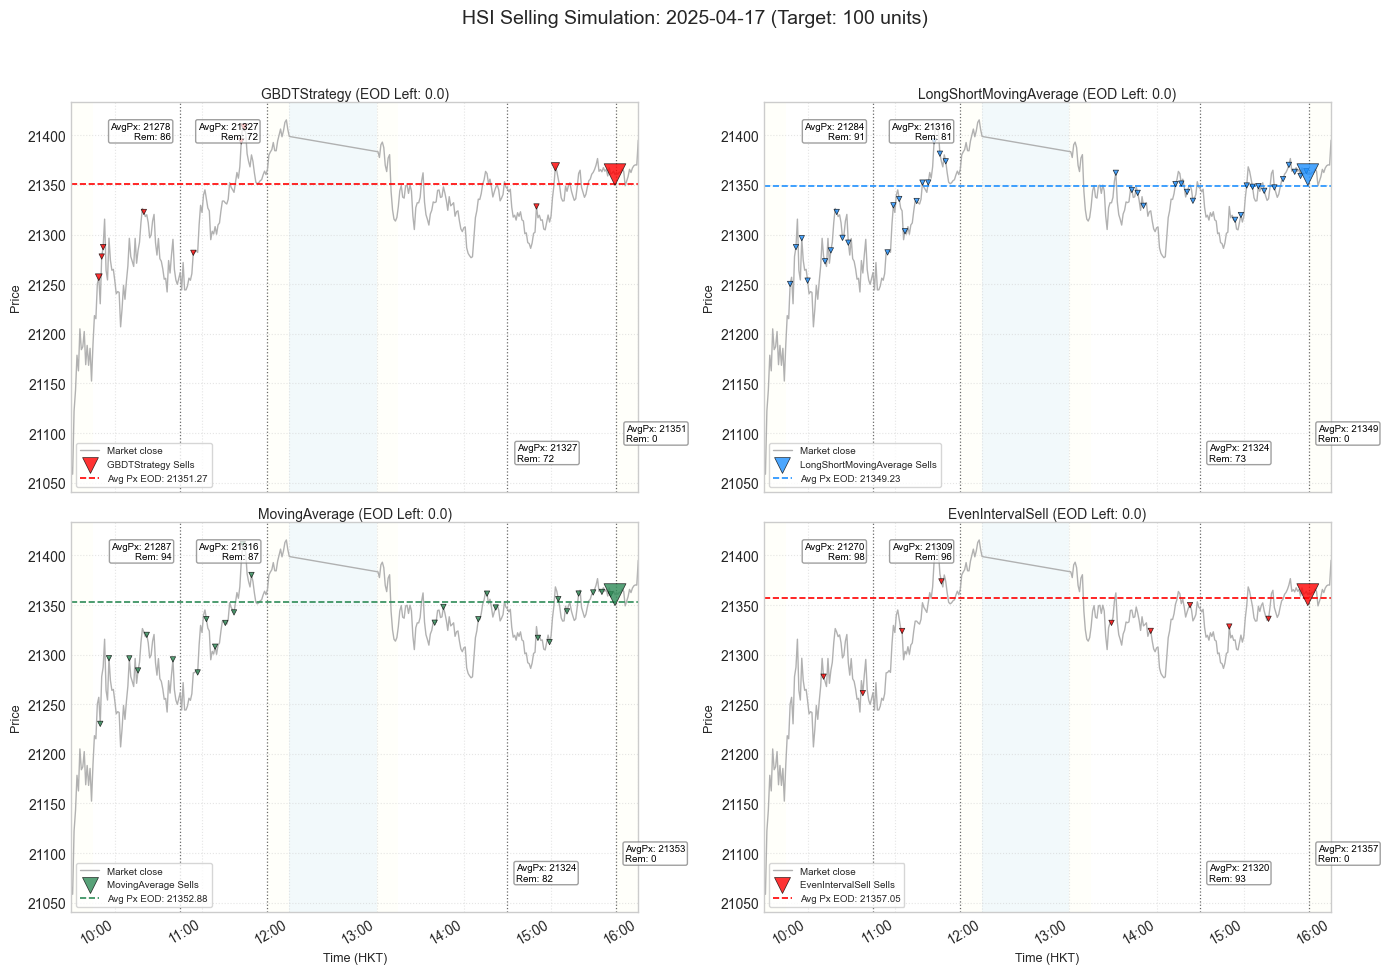


--- Average Daily Performance Across All Simulated Days ---
                        Overall Avg Sell Price  Avg Daily Cash  \
Algorithm                                                        
GBDTStrategy                          22684.69      2268468.89   
LongShortMovingAverage                22614.38      2261438.49   
MovingAverage                         22614.05      2261405.09   
EvenIntervalSell                      22613.80      2261380.41   

                        Avg Daily Units Sold  Avg Daily Return vs Arrival  \
Algorithm                                                                   
GBDTStrategy                          100.00                        91.81   
LongShortMovingAverage                100.00                        21.51   
MovingAverage                         100.00                        21.18   
EvenIntervalSell                      100.00                        20.93   

                        Avg Daily Sharpe  Avg Daily Trades  \
Algorithm        

In [11]:
run_simulation(featured_data_full, detailed_test_date_ts, all_unique_dates_ts, algorithms)